In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np

# Atoms
from ase.io import read
from ase.geometry import distance

# ML
from regression import SparseKRR
from kernels import build_kernel, linear_kernel, gaussian_kernel
from split import simple_split

# Utilities
from tools import load_json
from selection import FPS, random_selection
from kernels import sqeuclidean_distances
import multiprocessing
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
from sklearn.svm import LinearSVC
import itertools
import h5py
import glob
import project_utils as utils
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt

# SOAP
from soap import quippy_soap, librascal_soap

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle
line_list = cosmostyle.linestyle_cycle

# Initial setup

In [3]:
# Setup SOAP parameters
soap_hyperparameters = dict(max_radial=12,
                            max_angular=9,
                            interaction_cutoff=6.0,
                            cutoff_smooth_width=0.3,
                            gaussian_sigma_constant=0.3)

# Checks on geometry optimization

In [4]:
# TODO: eliminate RWY and the 5 deem structures

In [5]:
# Load indices of optimized structures
idxs_opt = np.loadtxt('../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH/rattled/vlist.idx', dtype=int)
n_iza = 225
idxs_opt = idxs_opt[idxs_opt >= n_iza] - n_iza

In [6]:
idxs_deem_train = np.sort(np.loadtxt('../Processed_Data/DEEM_10k/idxs_bk/train.idxs', dtype=int)) ##
idxs_iza_train = np.sort(np.loadtxt('../Processed_Data/IZA_226/idxs_bk/train.idxs', dtype=int)) ##

In [7]:
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
RWY = np.nonzero(cantons_iza == 4)[0][0]

In [8]:
deem_delete = np.loadtxt('../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)
deem_ids = np.arange(0, 331172)
deem_ids = np.delete(deem_ids, deem_delete) + 8000001

In [26]:
# Load old SOAPs
old_soaps_deem_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
old_soaps_deem = old_soaps_deem_file['0'][idxs_deem_train, :]
old_soaps_deem_opt = old_soaps_deem_file['0'][idxs_opt, :]
old_soaps_deem_file.close()

old_soaps_iza = utils.load_hdf5('../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5',
                                datasets=None, concatenate=True)
old_soaps_iza = np.delete(old_soaps_iza, RWY, axis=0)
old_soaps_iza = old_soaps_iza[idxs_iza_train]

old_soaps = np.vstack((old_soaps_iza, old_soaps_deem))

In [27]:
# Load old decision functions
old_df = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_dfs.dat')[idxs_opt, :]
old_cantons = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)[idxs_opt]

In [28]:
# Load corresponding xyz
cif_glob = sorted(glob.glob('../Raw_Data/GULP/DEEM_330k/Geometry/8*/*_opt.cif'))
orig_cif_glob = [s.replace('Geometry/', '') for s in cif_glob]

deem_opt = [read(cif_file, format='cif') for cif_file in cif_glob]
deem_orig = [read(cif_file, format='cif') for cif_file in orig_cif_glob]

/home/helfrech/ENVIRONMENTS/ZEOLITES/lib/python3.6/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'triclinic' is not interpreted for space group 1. This may result in wrong setting!
  setting_name, spacegroup))


In [29]:
# Large numbers likely due to the 0/1 cell boundary
for opt, orig, glob in zip(deem_opt, deem_orig, orig_cif_glob):
    print(os.path.basename(glob), distance(opt, orig))

8129307_opt.cif 0.005578273140481637
8129502_opt.cif 23.256612886185803
8154451_opt.cif 0.016386181675007588
8162067_opt.cif 0.0010614732815458336
8171809_opt.cif 0.005712884170824324
8286860_opt.cif 0.003068503597901241
8301971_opt.cif 0.0030227870219129453


In [30]:
opt_soaps = librascal_soap(deem_opt, [14],
                           **soap_hyperparameters,
                           normalize=False, 
                           average=True, 
                           concatenate=True)

100%|██████████| 7/7 [00:00<00:00, 84.46it/s]


In [31]:
print(np.linalg.norm(opt_soaps - old_soaps_deem_opt, axis=1))

[1.63085554e-06 7.37870407e-07 7.52730881e-07 2.45267341e-07
 1.07735862e-06 1.34693209e-07 1.77601459e-07]


In [32]:
soap_scale = np.std(old_soaps)

lsvc = LinearSVC()
lsvc_dict = load_json('../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc.json', array_convert=True)
lsvc.__dict__ = lsvc_dict

opt_df = lsvc.decision_function(opt_soaps / soap_scale)
opt_cantons = lsvc.predict(opt_soaps / soap_scale)

In [33]:
opt_df

array([[ -3.43832451, -10.28983252,  -8.02390094,   4.11378737],
       [ -6.2380323 ,  -5.30778473,  -3.14313988,   2.93446246],
       [ -4.64386883, -12.86502215,  -9.81393548,   6.89819009],
       [ -6.52820209,  -5.710208  ,  -2.00586572,   0.19344744],
       [ -5.89627736, -17.98955797,  -7.07448019,   6.19365991],
       [ -3.2686013 ,  -3.32880773,  -8.45304135,   3.30751157],
       [ -4.19626375,  -2.36694088,  -5.17583915,   0.76675821]])

In [34]:
old_df

array([[ -3.60330169, -10.78943244,  -8.40059917,   4.32851384],
       [ -6.51514771,  -5.53944611,  -3.27410005,   3.06077119],
       [ -4.84927237, -13.43976356, -10.25483399,   7.21259196],
       [ -6.80901789,  -5.95515394,  -2.09624478,   0.20685544],
       [ -6.14058224, -18.79316499,  -7.40798185,   6.48128434],
       [ -3.40779344,  -3.46982879,  -8.81643724,   3.45102412],
       [ -4.37463058,  -2.47206854,  -5.40254089,   0.80355065]])

In [35]:
print((opt_df - old_df) / old_df * 100)

[[-4.57850025 -4.63045596 -4.48418286 -4.96074351]
 [-4.25340178 -4.18203136 -3.99988301 -4.12669628]
 [-4.23576    -4.276425   -4.29942124 -4.35906925]
 [-4.12417484 -4.11317559 -4.31147445 -6.48182047]
 [-3.97852958 -4.27606003 -4.50192321 -4.43776904]
 [-4.08452404 -4.0642082  -4.12179975 -4.15854971]
 [-4.07730021 -4.25261917 -4.19620591 -4.57873278]]


In [36]:
print(np.linalg.norm(opt_df - old_df, axis=1))
for idx, i in enumerate(idxs_opt):
    print(deem_ids[i], opt_cantons[idx], old_cantons[idx])

[0.6817819  0.40443096 0.81594016 0.38367196 0.94837771 0.43807969
 0.30921499]
8129309 4 4
8129504 4 4
8154453 4 4
8162069 4 4
8171811 4 4
8286863 4 4
8301974 4 4


# Find IZA in DEEM 330k

In [19]:
labels_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=0, dtype='3U')
RWY = np.nonzero(labels_iza == 'RWY')[0][0]
labels_iza = np.delete(labels_iza, RWY)

In [20]:
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
cantons_iza = np.delete(cantons_iza, RWY)

In [21]:
#pcantons_iza = np.loadtxt('../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)
pcantons_iza = np.loadtxt('../Processed_Data/IZA_226/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)
# Don't delete predicted! RWY has already been removed!

In [22]:
# Predicted Deem cantons
#cantons_deem = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/2-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)
cantons_deem = np.loadtxt('../Processed_Data/DEEM_330k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)

In [23]:
# Load old SOAPs
deem_soaps_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0']

iza_soaps = utils.load_hdf5('../Processed_Data/IZA_226/Data/6.0/soaps_power_full_avg_nonorm.hdf5',
                                                datasets=None, concatenate=True)
iza_soaps = np.delete(iza_soaps, RWY, axis=0)

In [24]:
batch_size = 10000
n_samples_330k = deem_soaps.len()
n_batches = n_samples_330k // batch_size
if n_samples_330k % batch_size > 0:
    n_batches += 1

In [25]:
D = []
for i in tqdm(range(0, n_batches)):
    D.append(np.sqrt(sqeuclidean_distances(deem_soaps[i*batch_size:(i+1)*batch_size, :], iza_soaps)))
    
D = np.vstack(D)

In [26]:
deem_soaps_file.close()

In [27]:
logD = np.log10(D)
logDmin = np.log10(np.amin(D, axis=0))

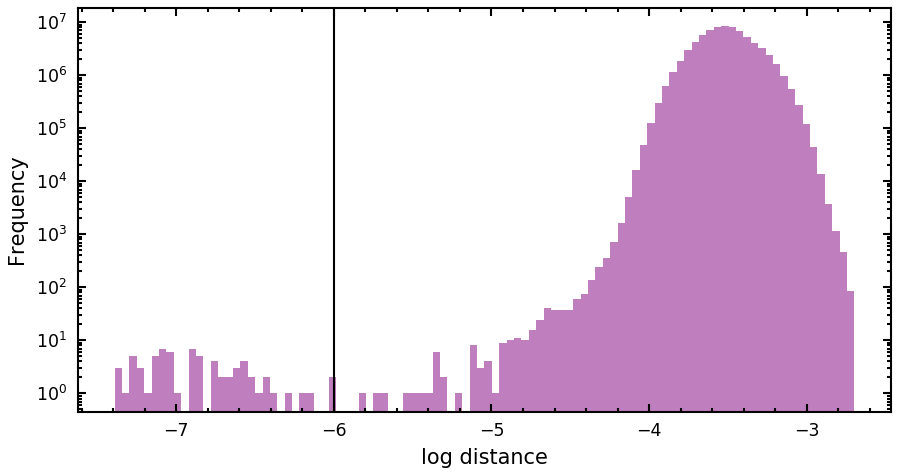

In [37]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

axs.hist(logD.flatten(), density=False, bins=100, log=True, facecolor=color_list[4], alpha=0.5)
#axs.hist(logDmin, density=False, bins=100, log=True, facecolor='silver')
#axs.set_xscale('log')
axs.axvline(-6, color=color_list[0])

axs.set_xlabel('log distance')
axs.set_ylabel('Frequency')

fig.savefig('../Results/6.0/similarity_histogram_6.0.pdf', bbox_inches='tight')
    
plt.show()

In [48]:
deem_idxs, iza_idxs = np.nonzero(logD <= -6)

In [49]:
len(iza_idxs), len(deem_idxs)

(69, 69)

In [50]:
arg_idxs = np.argsort(iza_idxs)
for i in arg_idxs:
    print(labels_iza[iza_idxs[i]], deem_idxs[i] + 8000001)

AEI 8077977
AFR 8068316
AFS 8323974
AFT 8330864
AFV 8321600
AFX 8321918
AFY 8054148
ANA 8308045
ASV 8307029
AVE 8322677
AVL 8321605
AWW 8072989
BEC 8067418
BOG 8298667
BPH 8327297
CHA 8068050
EAB 8321606
EMT 8325727
ERI 8321602
ESV 8252730
ETR 8322713
EZT 8132964
FAU 8307996
FER 8115812
FRA 8323748
GIS 8000282
GME 8077978
GON 8166073
GOO 8158586
HEU 8094207
IFO 8236886
IFY 8306634
ISV 8316304
ITE 8082737
IWR 8060435
IWV 8285528
KFI 8307701
LEV 8095118
LTJ 8046159
LTL 8322711
MAZ 8323247
MEI 8324829
MEL 8311069
MOR 8115524
MRT 8119854
MSO 8324148
NES 8285546
OFF 8321330
PHI 8056793
PON 8168597
POR 8309058
POS 8318264
RHO 8306957
RTE 8048551
SAF 8295280
SAO 8309154
SAS 8085224
SAV 8308796
SBE 8320023
SBS 8328215
SFW 8324260
SIV 8077983
STI 8186325
STW 8325990
SWY 8330642
TSC 8320020
UEI 8053433
UOZ 8307096
ZON 8123580


In [51]:
idx_ssf = np.nonzero(labels_iza == 'SSF')[0][0]
print(np.argmin(D[:, idx_ssf]) + 8000001)
print(D[8325096-8000001, idx_ssf])
print(np.sort(D[:, idx_ssf]))
print(np.nonzero(D[:, idx_ssf] < D[8325096-8000001, idx_ssf])[0])

8109211
8.398814797753112e-05
[6.91656240e-05 7.16562795e-05 7.47337303e-05 ... 1.45927027e-03
 1.55040669e-03 1.59108142e-03]
[ 67282  68836  70548  70899  70961  72358  73780  76669  77347  77404
  91214  98088 100537 100872 103070 103347 103410 106451 108044 108536
 109121 109210 178540 178716 179628 180201 200063 210077 242172 245592
 254177 256473 259501 259805 260829 263325 303171]


In [52]:
for idx_deem, idx_iza in zip(deem_idxs, iza_idxs):
    print(labels_iza[idx_iza], pcantons_iza[idx_iza], idx_deem+8000001, cantons_deem[idx_deem])
    
print(np.count_nonzero(pcantons_iza[iza_idxs] == cantons_deem[deem_idxs]) / len(deem_idxs))

GIS 3 8000282 3
LTJ 4 8046159 4
RTE 1 8048551 1
UEI 3 8053433 3
AFY 3 8054148 3
PHI 2 8056793 2
IWR 2 8060435 2
BEC 1 8067418 1
CHA 3 8068050 3
AFR 2 8068316 2
AWW 3 8072989 3
AEI 3 8077977 3
GME 2 8077978 2
SIV 2 8077983 2
ITE 2 8082737 2
SAS 3 8085224 3
HEU 2 8094207 2
LEV 2 8095118 2
MOR 2 8115524 2
FER 1 8115812 1
MRT 3 8119854 3
ZON 3 8123580 3
EZT 2 8132964 2
GOO 2 8158586 2
GON 2 8166073 2
PON 4 8168597 4
STI 2 8186325 2
IFO 4 8236886 4
ESV 2 8252730 2
IWV 2 8285528 2
NES 2 8285546 2
SAF 3 8295280 3
BOG 2 8298667 2
IFY 1 8306634 1
RHO 2 8306957 2
ASV 3 8307029 3
UOZ 3 8307096 3
KFI 3 8307701 3
FAU 2 8307996 2
ANA 4 8308045 4
SAV 3 8308796 3
POR 4 8309058 4
SAO 2 8309154 2
MEL 2 8311069 2
ISV 1 8316304 1
POS 2 8318264 2
TSC 2 8320020 2
SBE 3 8320023 3
OFF 2 8321330 2
AFV 3 8321600 3
ERI 2 8321602 2
AVL 3 8321605 3
EAB 2 8321606 2
AFX 3 8321918 3
AVE 2 8322677 2
LTL 2 8322711 2
ETR 3 8322713 3
MAZ 4 8323247 4
FRA 2 8323748 2
AFS 2 8323974 2
MSO 2 8324148 2
SFW 2 8324260 2
MEI 2 83

In [53]:
# Look at identical DEEM structure predictions
cantons_deem_10k = np.loadtxt('../Processed_Data/DEEM_10k/Data/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/svc_structure_cantons.dat', dtype=int)

In [55]:
idxs_deem_10k = np.loadtxt('../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [56]:
np.all(cantons_deem[idxs_deem_10k] == cantons_deem_10k)

True

In [59]:
soaps_deem_10k = utils.load_hdf5('../Processed_Data/DEEM_10k/Data/6.0/soaps_power_full_avg_nonorm.hdf5',
                                                datasets=None, concatenate=True)

In [60]:
deem_soaps_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0'][idxs_deem_10k]
deem_soaps_file.close()

In [61]:
D_deem = sqeuclidean_distances(deem_soaps, soaps_deem_10k)
D_deem[D_deem < 0.0] = 0.0
D_deem = np.sqrt(D_deem)

In [62]:
print(np.amax(D_deem), np.amin(D_deem), np.mean(D_deem))

0.0013528824539648006 0.0 0.00026466689301142993


# Energy Histograms and GCH Distances (RWY, 5 Deem removed)

In [9]:
cantons_iza = np.loadtxt('../Raw_Data/GULP/IZA_226/cantons.txt', usecols=1, dtype=int)
iza_delete = np.nonzero(cantons_iza == 4)[0][0]
deem_delete = np.loadtxt('../Processed_Data/DEEM_330k/10kJmol_error.idxs', dtype=int)

In [11]:
# Structure energies
deem_330k_energies = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary_fix.dat', usecols=2)
deem_330k_energies = np.delete(deem_330k_energies, deem_delete)

# TODO: change this when IZA re-optimized
iza_energies = np.loadtxt('../Processed_Data/IZA_226/Data/structure_energies.dat')
iza_energies = np.delete(iza_energies, iza_delete)
n_iza = len(iza_energies)

energies = np.concatenate((iza_energies, deem_330k_energies))

In [12]:
from scipy.spatial import ConvexHull

In [13]:
# Hull distances (TODO: change this so we just save all the useful properties from the GCH notebook)
gch_dir = '../Processed_Data/Models/6.0/Linear_Models/LSVC-LPCovR/4-Class/Power/OO+OSi+SiSi/GCH'
vprobprune = np.loadtxt(f'{gch_dir}/rattled/vprobprune.dat')
T = np.loadtxt(f'{gch_dir}/T.dat')
ndim = 3

gch_vertices = np.nonzero(vprobprune[-1])[0]

e_gch = energies[gch_vertices]
T_gch = T[gch_vertices, :]

eT = np.hstack((e_gch[:, np.newaxis], T_gch))
eT_all = np.hstack((energies[:, np.newaxis], T))
vertex_hull = ConvexHull(eT[:, 0:ndim])

# Omit simplices on the "top" of the GCH
vertex_hull_facets = np.delete(vertex_hull.equations, 
                               np.nonzero(vertex_hull.equations[:, 0] > 0.0),
                               axis=0)

d = -(np.matmul(eT_all[:, 0:ndim], vertex_hull_facets[:, 0:-1].T) + vertex_hull_facets[:, -1])
de = -d / vertex_hull_facets[:, 0]
d = np.amin(np.abs(d), axis=1)
de = np.amin(np.abs(de), axis=1)

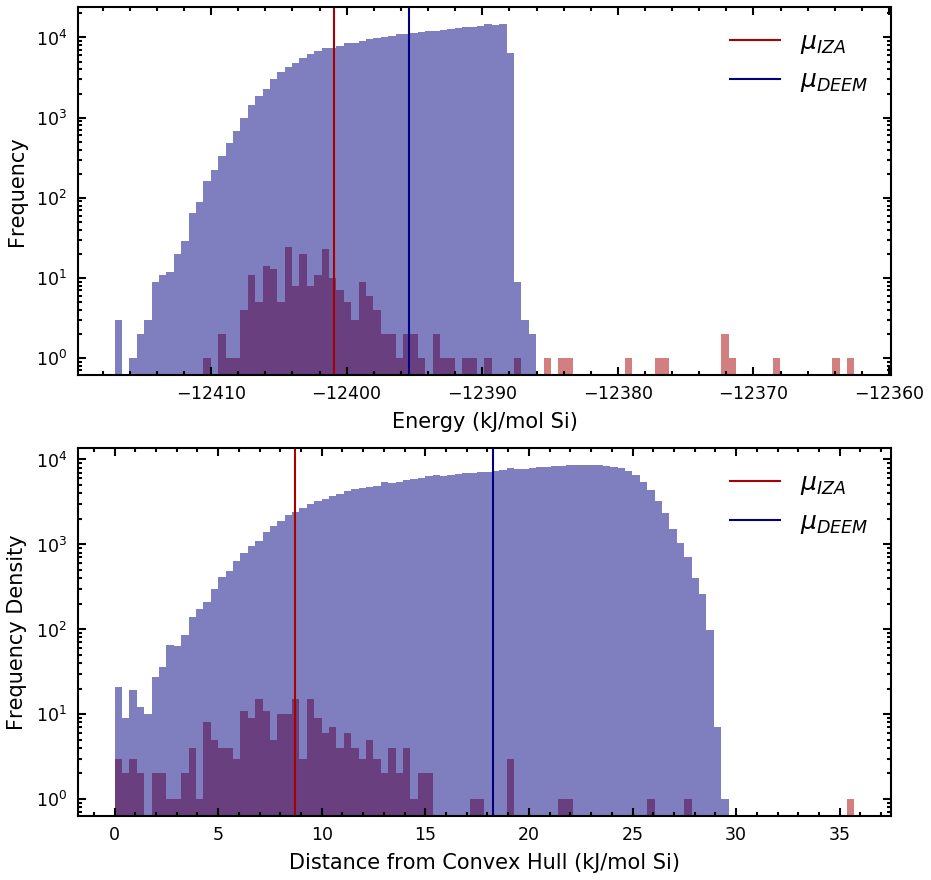

In [17]:
fig = plt.figure(figsize=(7.0, 7.0))
axs_energy = fig.add_subplot(2, 1, 1)
axs_hull = fig.add_subplot(2, 1, 2)

energy_histogram_parameters = dict(
    range=(np.amin(energies), np.amax(energies)), 
    density=False, bins=100, log=True, alpha=0.5
)

hull_histogram_parameters = dict(
    range=(np.amin(de), np.amax(de)),
    density=False, bins=100, log=True, alpha=0.5
)

# Histogram of GULP energies
axs_energy.hist(energies[0:n_iza], **energy_histogram_parameters, facecolor=color_list[1])
axs_energy.axvline(np.mean(energies[0:n_iza]), color=color_list[1], label=r'$\mu_{IZA}$')

axs_energy.hist(energies[n_iza:], **energy_histogram_parameters, facecolor=color_list[2])
axs_energy.axvline(np.mean(energies[n_iza:]), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_energy.set_ylabel('Frequency')
axs_energy.set_xlabel('Energy (kJ/mol Si)')
axs_energy.ticklabel_format(axis='x', style='plain', scilimits=(0, 0), useMathText=True)

axs_energy.legend(fontsize='large')

# Histogram of (energy) distances from convex hull
axs_hull.hist(de[0:n_iza], **hull_histogram_parameters, facecolor=color_list[1])
axs_hull.axvline(np.mean(de[0:n_iza]), color=color_list[1], label=r'$\mu_{IZA}$')

axs_hull.hist(de[n_iza:], **hull_histogram_parameters, facecolor=color_list[2])
axs_hull.axvline(np.mean(de[n_iza:]), color=color_list[2], label=r'$\mu_{DEEM}$')

axs_hull.set_ylabel('Frequency Density')
axs_hull.set_xlabel('Distance from Convex Hull (kJ/mol Si)')

axs_hull.legend(fontsize='large')

fig.savefig('../Results/6.0/energy_hull_histogram_6.0.pdf', bbox_inches='tight')

plt.show()